In [1]:
# 맥 한글 설정

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 1. 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux (예: colab)
    plt.rcParams['font.family'] = 'NanumGothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('스마트팜_수정데이터.csv', encoding='euc-kr')

In [4]:
# 필요없는 컬럼 제거
df1 = df.drop(['체세포', '축종코드', '제조사 아이디', '수집건수', '측정일시'], axis=1)

In [5]:
# 농장아이디, 개체번호 카테고리화
df1['개체번호'] = df1['개체번호'].astype('category')
df1['농장아이디'] = df1['농장아이디'].astype('category')

In [6]:
# 혈액흐름 인코딩
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
df1['혈액흐름'] = encoder.fit_transform(df1[['혈액흐름']])

In [7]:
# 유단백 대비 유지방 컬럼 생성
df1['PFR'] = round(df1['유단백'] / df1['유지방'], 3)

In [8]:
# 착유 소요 시간 컬럼 생성
df1['착유시작일시'] = pd.to_datetime(df1['착유시작일시'], format='%Y-%m-%d %H:%M')
df1['착유종료일시'] = pd.to_datetime(df1['착유종료일시'], format='%Y-%m-%d %H:%M')
df1['착유소요시간(분)'] = (df1['착유종료일시'] - df1['착유시작일시']).dt.total_seconds()/60

In [9]:
# 결측값 제거
df1 = df1.dropna()

### 이상탐지

#### one-class SVM

In [10]:
# 이상탐지에 사용할 컬럼

columns = ['공기흐름', '착유소요시간(분)']
detect_outlier = df1[columns].copy()

In [11]:
# one class SVM 이전 스케일링

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
detect_outlier_scaled = scaler.fit_transform(detect_outlier)

In [13]:
# one class SVM

from sklearn.svm import OneClassSVM

svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
y_pred_svm = svm.fit_predict(detect_outlier_scaled)

detect_outlier['outliers_svm'] = y_pred_svm

In [14]:
# 이상치로 예측된 샘플 인덱스 추출
outliers_svm = np.where(y_pred_svm == -1)[0]

print('=== One Class SVM ===')
print('이상치로 탐지된 샘플 개수: ', len(outliers_svm))
print('이상치 인덱스: ', outliers_svm)

=== One Class SVM ===
이상치로 탐지된 샘플 개수:  861
이상치 인덱스:  [   15    26    28    99   115   198   206   208   210   230   232   235
   247   251   290   325   374   378   384   385   400   569   586   602
   675   695   711   815  1092  1137  1189  1199  1201  1209  1219  1224
  1232  1234  1280  1286  1300  1302  1322  1420  1545  1582  1657  1671
  1756  1757  1766  1784  1794  1933  1998  2078  2153  2165  2374  2375
  2454  2455  2502  2503  2532  2533  2544  2545  2662  2663  2898  2899
  2900  2901  2938  2939  2970  2971  3086  3087  3176  3177  3206  3207
  3230  3231  3314  3315  3372  3373  3378  3379  3450  3451  3462  3463
  3468  3469  3482  3483  3506  3507  3542  3543  3666  3667  3792  3793
  3830  3831  4194  4195  4200  4201  4218  4219  4220  4221  4224  4225
  4226  4227  4318  4319  4432  4433  4470  4471  4482  4483  4492  4493
  4600  4601  4602  4603  4674  4675  4706  4707  4708  4709  4720  4721
  4754  4755  4758  4759  4808  4809  4874  4875  4880  4881  4934  493

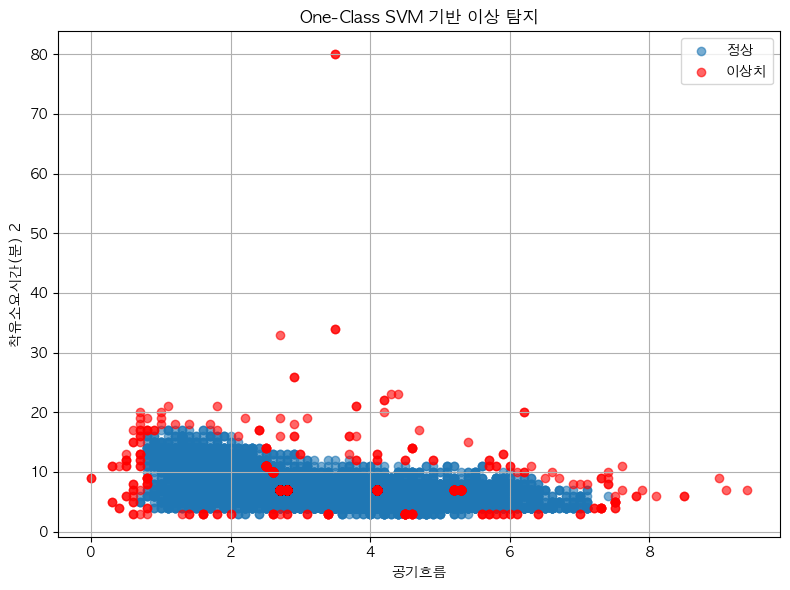

In [ ]:
# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    detect_outlier[detect_outlier['outliers_svm'] == 1]['공기흐름'],
    detect_outlier[detect_outlier['outliers_svm'] == 1]['착유소요시간(분)'],
    label='정상', alpha=0.6
)
plt.scatter(
    detect_outlier[detect_outlier['outliers_svm'] == -1]['공기흐름'],
    detect_outlier[detect_outlier['outliers_svm'] == -1]['착유소요시간(분)'],
    label='이상치', color='red', alpha=0.6
)
plt.xlabel('공기흐름')
plt.ylabel('착유소요시간(분)')
plt.title('One-Class SVM 기반 이상 탐지')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

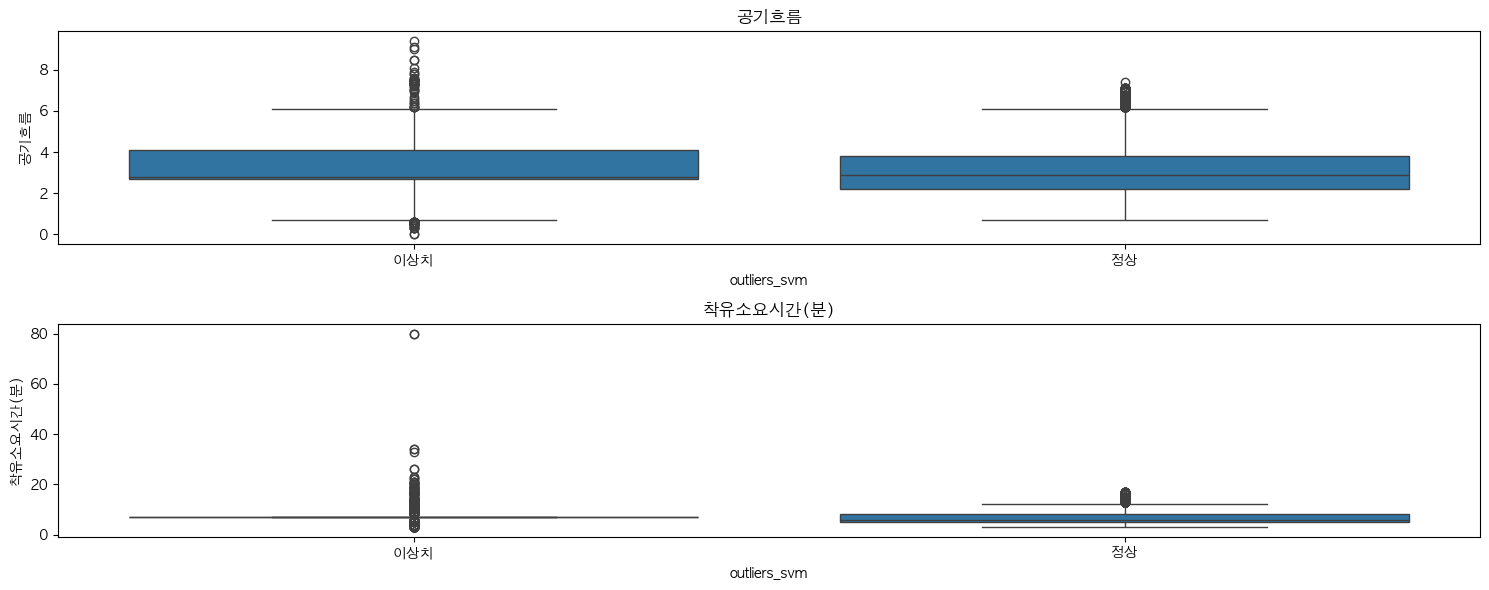

In [16]:
# box plot 시각화

import seaborn as sns

# 정상과 이상치 분리
normal_df = detect_outlier[detect_outlier['outliers_svm'] == 1]
outlier_df = detect_outlier[detect_outlier['outliers_svm'] == -1]

# boxplot 비교
plt.figure(figsize=(15, 6))
for i, feature in enumerate(columns):
    plt.subplot(2, (len(columns) + 1) // 2, i + 1)
    sns.boxplot(data=detect_outlier, x='outliers_svm', y=feature)
    plt.xticks([0, 1], ['이상치', '정상'])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [20]:
detect_outlier['outliers_svm'] == 1

0        True
1        True
2        True
3        True
4        True
         ... 
27921    True
27922    True
27923    True
27924    True
27925    True
Name: outliers_svm, Length: 27874, dtype: bool

In [18]:
# 이상탐지 후 정상 데이터만으로 착유량 예측

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df_clean = df1[detect_outlier['outliers_svm'] == 1].copy()

feature_cols = ['전도도', '온도', '유지방', '유단백', '공기흐름', 'PFR', '착유소요시간(분)']
X = df_clean[feature_cols]
y = df_clean['착유량']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"- RMSE: {rmse:.3f}\n- R² Score: {r2:.3f}")

- RMSE: 1.553
- R² Score: 0.815


In [19]:
# 분포 확인
df_clean.describe()

,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,수집일자,PFR,착유소요시간(분)
count,27013.000000,27013,27013,27013.000000,27013.000000,27013.000000,27013.000000,27013.000000,27013.000000,27013.000000,2.701300e+04,27013.000000,27013.000000
mean,11.578018,2021-09-14 23:36:28.235293952,2021-09-14 23:43:23.566430976,2.086884,6.905890,0.999408,39.293659,3.959512,3.164599,3.061496,2.021092e+07,0.834693,6.922186
min,0.000000,2021-09-01 00:03:00,2021-09-01 00:10:00,1.000000,3.200000,0.000000,35.800000,0.200000,2.400000,0.700000,2.021090e+07,0.358000,3.000000
25%,9.000000,2021-09-08 21:36:00,2021-09-08 21:42:00,1.000000,6.700000,1.000000,38.900000,3.500000,3.000000,2.200000,2.021091e+07,0.705000,5.000000
50%,11.000000,2021-09-15 14:23:00,2021-09-15 14:31:00,2.000000,6.900000,1.000000,39.300000,4.000000,3.200000,2.900000,2.021092e+07,0.800000,6.000000
75%,14.000000,2021-09-21 07:24:00,2021-09-21 07:32:00,3.000000,7.200000,1.000000,39.600000,4.400000,3.300000,3.800000,2.021092e+07,0.914000,8.000000
max,28.000000,2021-09-26 23:58:00,2021-09-27 00:11:00,6.000000,10.000000,1.000000,42.600000,8.100000,5.400000,7.400000,2.021093e+07,21.000000,17.000000
std,3.656169,NaN,NaN,1.010259,0.559181,0.024331,0.576817,0.753197,0.218361,1.116824,7.331577e+00,0.278804,2.127545
